# 1. 생성 모델 기초

## 1-1. 생성 모델이란?

생성 모델 : $p(x)$

$x$가 발생할 확률 분포(Probability distribution) $p(x)$를 알면 새로운 샘플을 생성할 수 있다. 확률론에서 $x$를 random vector라고 하는데, 비전에서는 $x$가 영상 또는 영상에서 추출한 feature vector를 의미한다. 생성 모델은 라벨 없이 $x$만으로 확률 분포를 추정하기 때문에 비지도 학습에 해당한다. 

데이터를 만들어내는 진짜 확률 분포를 $p_{data}$, 주어진 데이터로부터 추정한 확률 분포를 $p_{model}$ 이라고 한다. 보통 $p_{data}$는 알 수 없고, 단지 데이터에서 근사 추정한 $p_{model}$만 알 수 있다. 확률론에 따르면 데이터의 크기가 커질수록 $p_{model}$은 $p_{data}$에 근사한다. 특징 개수가 적고 특징의 몇 개의 이산값만 가지면 쉽게 확률 분포를 계산하여 배열로 표현할 수 있는데 이런 경우를 tractable하다고 한다.

확률 분포를 추정하는 경우, 실제 데이터에서는 특징 벡터의 차원이 매우 크고, 특징은 아주 많은 값이 가능하다. 예를 들어 MNIST 데이터는 특징 벡터 $x$는 784차원을 갖고 있으며, 특징이 같을 수 있는 값은 [0,255] 사이의 정수이다. 따라서 MNIST를 배열로 확률 분포를 표현하면 $256^{784}$개의 요소가 필요하여 이 경우엔 intractable하다. 더욱이 특징이 실수인 경우에는 배열 표현이 아예 불가능하다. 

생성 모델에서는 tractable을 벗어나지 않으면서 가능한 한 $p_{model}$이 $p_{data}$에 가깝도록 모델링하는 기법을 찾는 일이다. 수식으로 표현하면 아래와 같다. 
$$p_{model}(x) \cong p_{data}(x)$$

## 1-2. 가우시안 혼합 모델

실제 데이터를 위한 생성 모델을 구성할 때, 가장 쉬운 방법은 tractable한 함수를 이용해 확률 분포를 추정하는 것이다. 이런 종류의 함수 중에 가장 널리 쓰이는 것은 Gaussian이다. 

### 특징 벡터가 2차원 실수 공간

변수가 2개인 상황일 때의 예시이다. 다양한 사람을 모집해 키, 몸무게를 잰 뒤 데이터셋을 얻었다고 가정하자. 데이터셋은 가우시안 분포(정규 분포)를 한다고 가정하고 아래 식의 확률 분포를 추정한다. 
$$ p(x) = N(\mu, \Sigma) $$

아래 코드는 numpy 모듈을 이용해 생성 모델을 제작한 것이다.

### (키, 몸무게)를 생성하는 생성 모델 제작

In [1]:
import numpy as np

X = np.array([[169,70],[172,68],[175,78],[180,73],[160,52],[167,45],[159,50],[175,69],[185,79],[192,89]])

# Gaussian mean & covaraiance matrix
m = np.mean(X, axis=0)
cv = np.cov(X, rowvar=False) # 두 변수 사이의 상관관계

gen = np.random.multivariate_normal(m, cv, 5) # 학습된 가우시안 모델(키, 몸무게)를 5개 생성

print(gen)

[[178.52543142  65.42501319]
 [166.11165823  60.26143849]
 [187.01835095  77.35209841]
 [176.89935904  72.30652971]
 [162.88550248  59.40113366]]


### MNIST를 가우시안 모델링하고 샘플 생성

/home/work/miniconda3/envs/aug/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


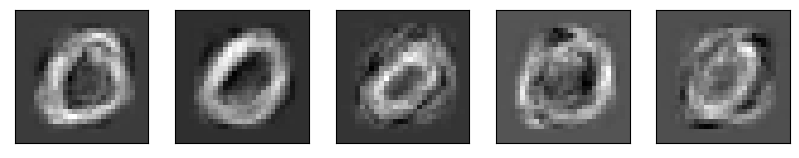

In [2]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# '0'으로 라벨링된 데이터만 선택
zero_indices = [i for i, (img, label) in enumerate(mnist_train) if label == 0]
zero_data = [mnist_train[i][0] for i in zero_indices]

# 데이터를 numpy 배열로 변환
zero_data_np = torch.stack(zero_data).numpy().reshape(len(zero_data), -1)

# 평균 및 공분산 계산
m = np.mean(zero_data_np, axis=0) # 784 차원의 벡터
cv = np.cov(zero_data_np, rowvar=False) # 784 x 784 matrix

# 새로운 데이터 생성
gen = np.random.multivariate_normal(m, cv, 5)

# 샘플 그리기
plt.figure(figsize=(10,4))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(gen[i].reshape(28, 28), cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.show()


생성 결과 숫자를 인식할 수는 있지만 잡음이 심한 낮은 품질의 샘플이 생성되는 것을 확인

## 가우시안 혼합 모델(GMM)

위 숫자 0을 모델링할 때는 하나의 가우시안으로 가능했지만, 0 이외의 10개의 숫자를 모델링하려면 하나의 가우시안으로는 불가능하다. 같은 숫자라도 두께나 기울기가 변하기 때문에 하나의 가우시안을 적용하는 것은 한계가 있다. 

<p align="center">
<img src = "./img/fig1.png" width="500">
</p>


위 그림은 가상의 데이터 분포를 예시한다. 3개 모드가 있는데 그림(b)는 모드를 찾아 각각을 가우시안으로 표현하는 가우시안 혼합 모델(GMM: Gaussian Mixture Model)을 개념적으로 보여준다. 아래 식은 GMM을 표현한다. 
$$ p(x) = \sum_{i=1,k} \pi_i N(\mu_i,\Sigma_i) $$

평균 $\mu$, 공분산 행렬 $\Sigma$인 가우시안을 $k$개 혼합하는 방식이다. $k$는 하이퍼 파리미터로 위 그림에서는 3이다. $\pi_i$는 $i$번째 가우시안의 가중치이다. 노란색으로 표시된 가우시안이 가장 많은 샘플을 갖기 때문에 $\pi_3$이 가장 크다고 할 수 있다. GMM은 $k$개의 $\mu, \Sigma, \pi$를 알아내야 한다. 보통 EM(Expectation Maximization) 알고리즘으로 GMM을 구한다. 

다시 위의 그림을 보면 가상의 데이터를 보여주는데, 기울기와 굵기가 다른 샘플이 군집 3개를 형성했다고 비유할 수 있다. 그림에서는 2차원 특징 공간으로 축소되었지만 MNIST 샘플은 784(28x28)차원이다. 

### MNIST를 GMM으로 모델링하고 샘플 생성

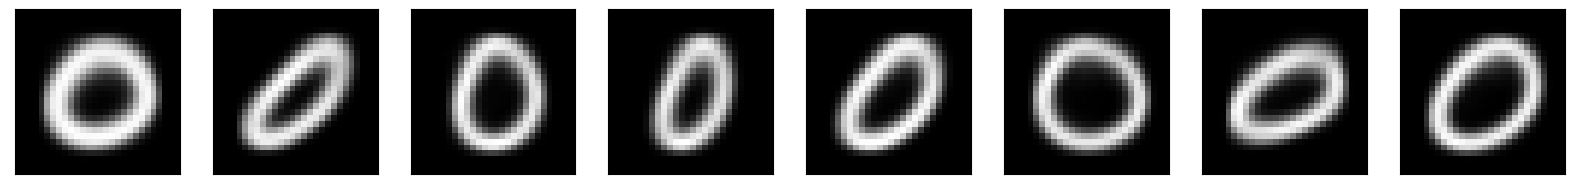

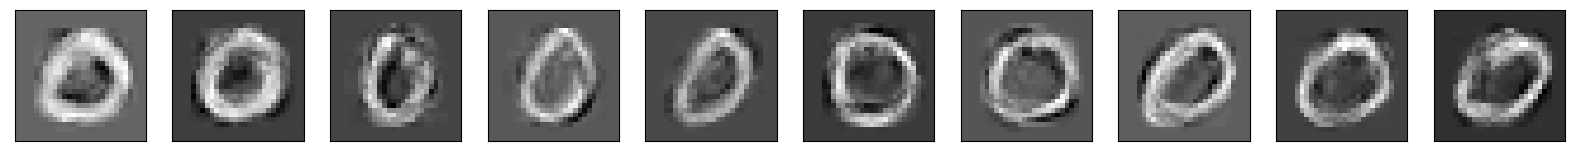

In [3]:
import numpy as np
import torch
from torchvision import datasets, transforms
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

transform = transforms.Compose([transforms.ToTensor()])

# MNIST 데이터셋을 로드합니다.
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)

dataiter = iter(train_loader)
images, labels = next(iter(train_loader))

# 0번 데이터만 선택
X = images[labels == 0]

X = X.reshape(X.shape[0], -1)

# numpy 배열로 변환
X = X.numpy()

k = 8
gm = GaussianMixture(n_components=k)
gm.fit(X)

gen, _ = gm.sample(n_samples=10)

# 생성된 가우시안 8개의 평균 그림
plt.figure(figsize=(20,4))
for i in range(k):
    plt.subplot(1, k, i+1)
    plt.imshow(gm.means_[i].reshape(28, 28), cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.show()

# 생성된 샘플 10개 그림
plt.figure(figsize=(20,4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(gen[i].reshape(28, 28), cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.show()


### 가우시안 혼합 모델의 한계

가우시안 혼합 모델은 데이터가 가우시안 분포를 한다는 가정을 통해 다룸 가능성을 확보하지만, 가우시안에 기반한 $p_{model}$이 진짜 확률 분포 $p_{data}$와 차이가 커서 생성 모델로서 한계가 있다. 

## 최대 우도

생성 모델은 $n$개의 샘플을 가진 데이터셋 $X = \lbrace x^1, x^2, ..., x^n \rbrace$ 으로 학습한다. 생성 모델의 학습 알고리즘은 데이터 $X$를 발생할 가능성이 가장 높은 매개변수 $\theta$를 추정하는 방식으로 동작한다. 이를 식으로 쓰면 아래와 같다. 
$$ \hat \theta = argmax \space p_\theta(X) \tag{5} $$

신경망으로 생성 모델을 구축하는 경우 신경망의 가중치가 $\theta$이다. 

$p_\theta(X)$를 우도(likelihood)라고 부르고, 위 식을 푸는 학습 알고리즘을 최대 우도법(maximum likelihood method)라고 한다. 아래 그림은 단순한 예시를 통해 최대 우도법을 설명한다. 

<p align="center">
<img src = "./img/fig2.png" width="350">
</p>

붉은색 점은 데이터셋인데, 왼쪽 빨간색 가우시안이 매개변수 $\theta_1$을, 오른쪽 파란색 매개변수 $\theta_2$을 가진 가우시안으로 모델링되었다고 하자. 이 경우 $p_{\theta_1}(X) > p_{\theta_2}(X)$ 이기 때문에 $\theta_1$이 더 좋은 모델이라고 할 수 있다. 다른 말로 하면 $\theta_1$ 이 $\theta_2$ 보다 데이터셋 $X$를 잘 설명한다고 할 수 있다. 수식 5의 최대 우도법은 가장 좋은 매개변수 $\hat \theta$를 찾는다. 

수식 5에서 $X$를 구성하는 $n$개의 샘플은 독립적으로 샘플링되었으므로 우도 $p_\theta(X)$를 아래 식과 같이 표현할 수 있다. 

$$ p_\theta(X) = \Pi^n_{i=1} p_\theta(x^i) = p_\theta(x^1) p_\theta(x^2) \cdot \cdot \cdot p_\theta(x^n) \tag{6}$$

보통 $n$은 매우 크기 때문에 수식 6은 아주 작아져 수치 오류가 발생할 수 있다. log 함수는 곱셈을 덧셈으로 바꾸기 때문에 보통 log 함수를 적용한 수식 7의 로그 우도(log likelihood)를 대신 사용한다. 수식 5의 최대 우도법은 최댓값 자체가 아니라 최댓값을 갖는 인덱스를 찾기 때문에 단조 증가 함수인 log를 적용한 다음 argmax를 적용해도 같은 결과를 얻기 때문이다. 

$$ \hat \theta = argmax \sum_{i=1}^n \space log \space p_\theta(x^i) \tag{7} $$